# Using a Transformer to Predict NFL Player Movements

#### Preprocessing

##### Load Data

In [ ]:
from google.colab import runtime
runtime.unassign()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

os.chdir('/content/drive/MyDrive/databowl/')
df = pd.read_csv('2023_tracking.csv')

In [ ]:
max_targets = df.groupby(['play_id_n', 'frame_id'])['player_to_predict'].sum().max()
print(max_targets)

9


##### Tabular to Pixel

In [ ]:
df_pixel = df.dropna()
df_pixel = df_pixel[(df_pixel['play_id_n'] >= 0) & (df_pixel['play_id_n'] <= 6000)]

In [ ]:
def pixel_map(player_data, target_player_ids, max_targets, grid_width=121, grid_height=55, sigma=.8):

    num_channels = 2 + max_targets + 1
    # three channels, one for offense, one for defense, one for ball location, one for player to predict
    pixel_map = np.zeros((num_channels, grid_height, grid_width), dtype=np.float32)

    x_vals = player_data['x'].values
    y_vals = player_data['y'].values

    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        x_min = max(0, int(np.floor(x - 2*sigma)))
        x_max = min(grid_width, int(np.ceil(x + 2*sigma)) + 1)
        y_min = max(0, int(np.floor(y - 2*sigma)))
        y_max = min(grid_height, int(np.ceil(y + 2*sigma)) + 1)

        for xi in range(x_min, x_max):
            for yi in range(y_min, y_max):
                dist_sq = (xi - x)**2 + (yi - y)**2
                weight = np.exp(-dist_sq / (2 * sigma**2))

                player_id = player_data.iloc[i].get('nfl_id', None)

                if player_id in target_player_ids:
                    target_idx = target_player_ids.index(player_id)
                    if target_idx < max_targets: # to prevent error
                        pixel_map[2 + target_idx, yi, xi] += weight
                elif player_data.iloc[i]['player_side'] == 'Offense':
                    pixel_map[0, yi, xi] += weight
                elif player_data.iloc[i]['player_side'] == 'Defense':
                    pixel_map[1, yi, xi] += weight


    ball_x = player_data['ball_land_x'].iloc[0]
    ball_y = player_data['ball_land_y'].iloc[0]

    ball_x_min = max(0, int(np.floor(ball_x - 2*sigma)))
    ball_x_max = min(grid_width, int(np.ceil(ball_x + 2*sigma)) + 1)
    ball_y_min = max(0, int(np.floor(ball_y - 2*sigma)))
    ball_y_max = min(grid_height, int(np.ceil(ball_y + 2*sigma)) + 1)

    for xi in range(ball_x_min, ball_x_max):
        for yi in range(ball_y_min, ball_y_max):
            dist_sq = (xi - ball_x)**2 + (yi - ball_y)**2
            weight = np.exp(-dist_sq / (2 * sigma**2))
            pixel_map[2 + max_targets, yi, xi] += weight

    return pixel_map

testing one play

In [ ]:
df_play_id = df_pixel[df_pixel['play_id_n'] == 0]
target_player_ids = df_play_id[df_play_id['player_to_predict'] == True]['nfl_id'].unique().tolist()
df_grids_t = df_play_id.groupby(['play_id_n','frame_id']).apply(
    lambda x: pd.Series({'grid': pixel_map(x, target_player_ids, max_targets)})
)

/tmp/ipython-input-3901214770.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grids_t = df_play_id.groupby(['play_id_n','frame_id']).apply(


grid for all plays

In [ ]:
df_grids = df_pixel.groupby(['play_id_n','frame_id']).apply(
    lambda x: pd.Series({'grid': pixel_map(x,  x[x['player_to_predict'] == True]['nfl_id'].unique().tolist(), max_targets)})
)

/tmp/ipython-input-1435863499.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grids = df_pixel.groupby(['play_id_n','frame_id']).apply(


In [ ]:
df_grids = df_grids.reset_index()
df_grids = df_grids.sort_values(['play_id_n', 'frame_id'])

visual test

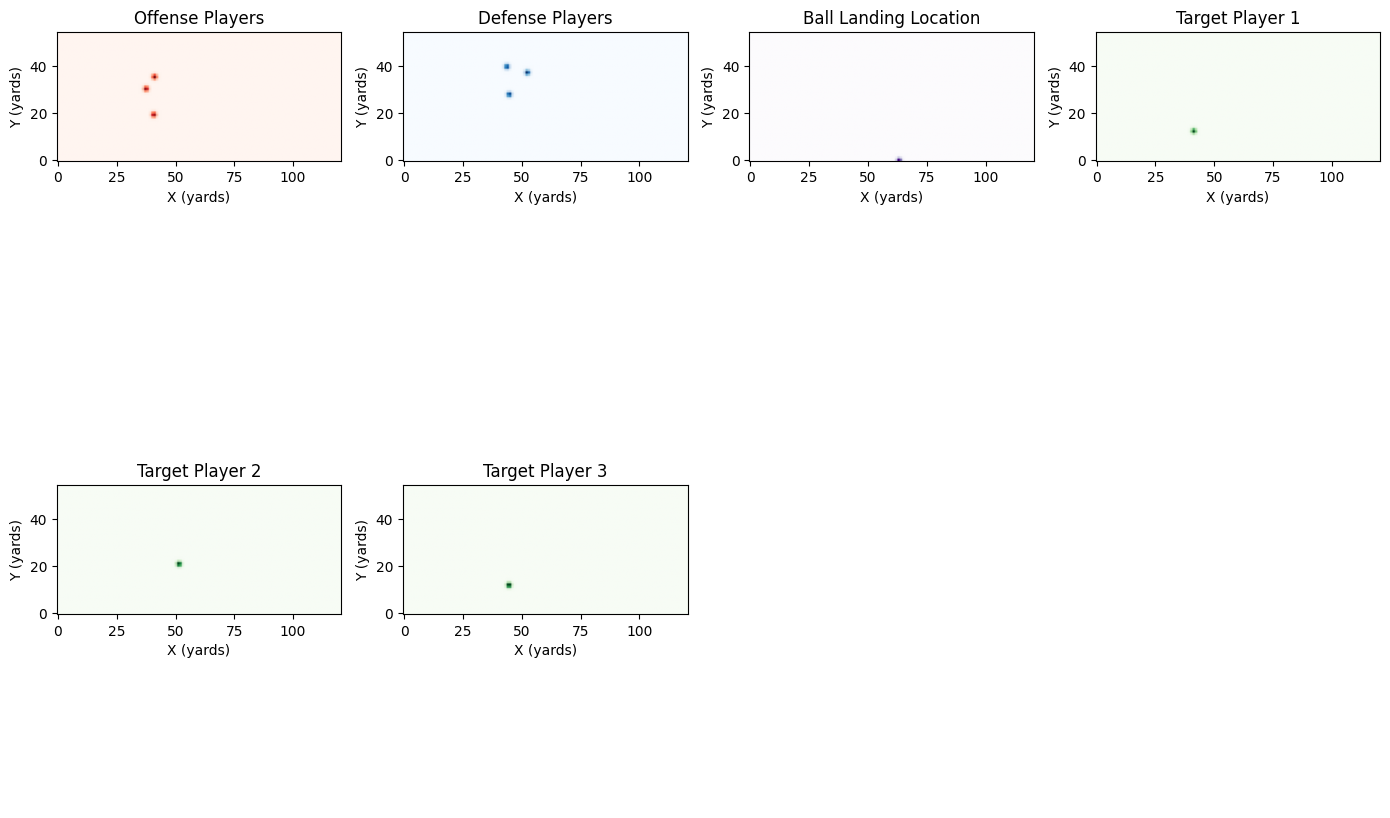

In [ ]:
sample_grid = df_grids_t['grid'].iloc[1]

# Count how many target player channels have data
num_targets = 0
for i in range(max_targets):
    if sample_grid[2 + i].sum() > 0:
        num_targets += 1

# Create subplots: 2 base channels + ball + target players
total_plots = 3 + num_targets
cols = 4
rows = (total_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 5*rows))
axes = axes.flatten() if total_plots > 1 else [axes]

# Plot offense
axes[0].imshow(sample_grid[0], origin='lower', cmap='Reds')
axes[0].set_title('Offense Players')
axes[0].set_xlabel('X (yards)')
axes[0].set_ylabel('Y (yards)')

# Plot defense
axes[1].imshow(sample_grid[1], origin='lower', cmap='Blues')
axes[1].set_title('Defense Players')
axes[1].set_xlabel('X (yards)')
axes[1].set_ylabel('Y (yards)')

# Plot ball location (at index 2 + max_targets)
axes[2].imshow(sample_grid[2 + max_targets], origin='lower', cmap='Purples')
axes[2].set_title('Ball Landing Location')
axes[2].set_xlabel('X (yards)')
axes[2].set_ylabel('Y (yards)')

# Plot each target player (channels 2 through 2+max_targets-1)
plot_idx = 3
for i in range(max_targets):
    if sample_grid[2 + i].sum() > 0:
        axes[plot_idx].imshow(sample_grid[2 + i], origin='lower', cmap='Greens')
        axes[plot_idx].set_title(f'Target Player {i+1}')
        axes[plot_idx].set_xlabel('X (yards)')
        axes[plot_idx].set_ylabel('Y (yards)')
        plot_idx += 1

for idx in range(total_plots, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
df_grids.to_pickle("full_grids_0_6000.pkl")

### Transformer

##### Packages

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import gc
from transformers import get_cosine_schedule_with_warmup
torch.manual_seed(26)

In [4]:
df_grids = pd.read_pickle("full_grids_0_6000.pkl")
df_grids2 = pd.read_pickle("full_grids_6001_13500.pkl")
df_grids2 = df_grids2.reset_index()
df_grids2 = df_grids2.sort_values(['play_id_n', 'frame_id'])
df_grids = pd.concat([df_grids, df_grids2])

In [5]:
play_ids = df_grids['play_id_n'].values
df = df[df['play_id_n'].isin(play_ids)]

##### Inital Params

In [6]:
max_targets = int(df.groupby(['play_id_n', 'frame_id'])['player_to_predict'].sum().max())
max_input = int((df['frame_id'] - df['num_frames_output']).max())
max_output = int((df['num_frames_output']).max())
print(max_targets)
print(max_input)
print(max_output)

9
123
94


##### Time Encoded

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, dropout, max_length=150):
        super(PositionalEncoding, self).__init__()
        # droput
        self.dropout = nn.Dropout(p=dropout)

        # create matrix
        pe = torch.zeros(max_length, embed_size)

        # position tensor shape
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)

        # div_term tensor shape
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_size))

        # apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)

        # apply cos to odd indices
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        # register as buffer so it moves with model to device
        self.register_buffer('pe', pe)

    def forward(self, x):
        pe_slice = self.pe[:x.size(1), :].to(x.device)
        x = x + pe_slice
        return self.dropout(x)

##### Player Positions

In [8]:
class PlayerPositionEmbedding(nn.Module):
    def __init__(self, embed_size, max_targets, num_positions = 18):
        super().__init__() # Added parentheses here
        self.embed_size = embed_size

        self.position_projection = nn.Embedding(num_positions, embed_size)

    def forward(self, player_positons, target_masks):
        # ints to learnable embedding space
        pos_embeds = self.position_projection(player_positons.long().squeeze(-1))

        # target mask, ignore padded values
        target_mask_expand = target_masks.unsqueeze(-1).expand_as(pos_embeds)
        pos_embeds = pos_embeds * target_mask_expand.float()

        return pos_embeds

localilty embeddings

In [9]:
class FourierEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim, scale=10.0):
        super().__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.scale = scale
        self.B = nn.Parameter(torch.randn(input_dim, embed_dim // 2) * scale, requires_grad=False)

        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        x_embed = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return self.out_proj(x_embed)


##### Encoding

In [10]:
class SpatialSoftmax(nn.Module):
  def __init__(self, height, width, device='cuda'):
    super(SpatialSoftmax, self).__init__()
    self.height = height
    self.width = width
    self.device = device

    pos_x, pos_y = np.meshgrid(np.linspace(-1., 1., width),
                               np.linspace(-1., 1., height))

    pos_x = torch.from_numpy(pos_x.reshape(self.height * self.width)).float().to(device)
    pos_y = torch.from_numpy(pos_y.reshape(self.height * self.width)).float().to(device)
    self.register_buffer('pos_x', pos_x)
    self.register_buffer('pos_y', pos_y)

  def forward(self, feature_map):
    B, C, H, W = feature_map.shape
    feature_flat = feature_map.view(B, C, -1)
    softmax_attn = F.softmax(feature_flat, dim=-1)

    expected_x = torch.sum(self.pos_x * softmax_attn, dim=2, keepdim = True)
    expected_y = torch.sum(self.pos_y * softmax_attn, dim=2, keepdim = True)

    expected_xy = torch.cat([expected_x, expected_y], dim=2)

    return expected_xy.view(B, -1)

class CNN_DownSample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # variable based on amount of targets
        input_chan = 2 + max_targets + 1

        self.heatmap_encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_chan, out_channels=32, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU()
        )

        self.spatial_softmax = SpatialSoftmax(height=14, width=31)

        # heatmap to embedding
        self.output_proj = nn.Linear(128, dim)

    def forward(self, x):
        x = self.heatmap_encoder(x)
        x = self.spatial_softmax(x)
        x = self.output_proj(x)
        return x

Encoder Block

In [11]:
class TransEncoder(nn.Module):
    def __init__(self, input_dim, embed_size, num_layers, nhead, device, dropout, mask, max_length):
        super(TransEncoder, self).__init__()
        # emebef size and deivice
        self.embed_size = embed_size
        self.device = device

        # learned matrix projection
        self.input_projection = nn.Linear(input_dim, embed_size)
        # postional encoding
        self.position_encoding = PositionalEncoding(embed_size, dropout, max_length)

        # transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=nhead,
            dim_feedforward=embed_size*2,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )

        # transformation encoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # normalize after attention
        self.norm = nn.LayerNorm(embed_size)

    def forward(self, x, mask):
        # input layer matrix mult
        projected_input = self.input_projection(x)
        # position encodings
        out = self.position_encoding(projected_input)
        # invert mask
        src_key_padding_mask = ~mask
        out = self.transformer_encoder(out, src_key_padding_mask=src_key_padding_mask)
        # normalize gradients
        out = self.norm(out)
        return out

##### Masks

In [12]:
# prevent lookahead
def create_causal_mask(seq_len, device):
    mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    return mask.bool()

# seq mask to deal with padded values
def seq_maks(input_lengths, max_input, device):
    batch_size = len(input_lengths)
    input_mask = torch.zeros(batch_size, max_input, device=device, dtype=torch.bool)
    for i, length in enumerate(input_lengths):
        input_mask[i, :length] = True

# loss with mask
def mse_with_length_mask(predictions, targets, combined_mask):
    mse = (predictions - targets) ** 2
    masked_mse = mse * combined_mask.float()

    valid_elements = combined_mask.sum()

    if valid_elements > 0:
        return masked_mse.sum() / valid_elements
    else:
        return torch.tensor(0.0, device=predictions.device)

##### Decoder

In [13]:
class TransDecoder(nn.Module):
    def __init__(self, target_mask, embedding, dropout, nhead, layers, max_targets, max_step_change, max_seq_len):
        super(TransDecoder, self).__init__()
        self.max_targets = max_targets
        self.max_seq_len = max_seq_len
        self.embedding = embedding
        self.max_step = max_step_change
        self.role_dim = 8

        # project 2d cords to embedding space
        self.start_pos_projection = FourierEmbedding(2, embedding, scale=1.0)

        # projection for movement
        self.delta_projection = FourierEmbedding(5, embedding, scale=10.0)

        # player pos embeddings
        self.player_pos_embedding = PlayerPositionEmbedding(self.role_dim, max_targets)

        # concat info
        self.input_fusion = nn.Linear(embedding + self.role_dim, embedding)

        # project outputs back to 2d space
        self.output_projection = nn.Linear(embedding, 5)

        # postional embeddings
        self.pos_embed = PositionalEncoding(embed_size=embedding, dropout=0.15, max_length=150)

        # decoder layers
        decoder_layer = nn.TransformerDecoderLayer(d_model=embedding,
                                                    nhead=nhead,
                                                    dim_feedforward=embedding*2,
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    norm_first=True)

        # decoder
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=layers)

        # norm
        self.norm = nn.LayerNorm(embedding)

    def forward(self, encoded_context, start_positions, target_mask, target_seq, player_position, encoder_padding_mask=None, train = True):
        # project all of the postion embeddings
        player_pos_embeds = self.player_pos_embedding(player_position, target_mask)
        # train vs validation
        if train:
            return self.train_forward(encoded_context, start_positions, target_seq, player_pos_embeds, encoder_padding_mask)
        else:
            return self.val_forward(encoded_context, start_positions, player_pos_embeds, encoder_padding_mask)

    def train_forward(self, encoded_context, start_positions, target_seq, player_pos_embeds, encoder_padding_mask):
        device = encoded_context.device
        B, T, S, _ = target_seq.shape

        # inital postion
        start_token = self.start_pos_projection(start_positions)
        start_token = start_token.unsqueeze(2)

        # ground truth deltas, we shift right, input at T2 is our target for t1
        shifted_targets = target_seq[:, :, :-1, :]
        delta_targets = self.delta_projection(shifted_targets) # project the change in pos sep from start, diff units

        # add noise to prevent overfitting
        noise = torch.rand_like(delta_targets) * 0.1
        delta_targets = delta_targets + noise

        # decoder input
        decoder_input = torch.cat([start_token, delta_targets], dim=2)

        # add player pos embeds
        seq_len = decoder_input.shape[2]
        role_embeds = player_pos_embeds.unsqueeze(2).expand(-1, -1, seq_len, -1)
        combined_input = torch.cat([decoder_input, role_embeds], dim = -1)
        decoder_input_fused = self.input_fusion(combined_input)

        # add time encoding
        decoder_input_reshaped = decoder_input_fused.view(B*T, S, self.embedding)
        decoder_input_encoded = self.pos_embed(decoder_input_reshaped)

        # prevent lookahead
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(S, device=device)

        # expand encoded context
        expanded_context = encoded_context.repeat_interleave(T, dim=0)

        if encoder_padding_mask is not None:
            memory_key_padding_mask = encoder_padding_mask.repeat_interleave(T, dim=0)
        else:
            memory_key_padding_mask = None


        decoded = self.transformer_decoder(tgt=decoder_input_encoded,
                                           memory=expanded_context,
                                           tgt_mask=tgt_mask,
                                           memory_key_padding_mask=memory_key_padding_mask)
        # batch norm
        decoded = self.norm(decoded)

        # predicted delta
        all_preds = self.output_projection(decoded)

        # reshape back to og targ seq shape
        return all_preds.view(B, T, S, 5)

    def val_forward(self, encoded_context, start_positions, player_pos_embeds, encoder_padding_mask):
      device = encoded_context.device
      batch_size = encoded_context.shape[0]

      # init pos
      current_input = self.start_pos_projection(start_positions).unsqueeze(2)

      # player pos embeddings
      role_embeds = player_pos_embeds.unsqueeze(2)
      combined_init = torch.cat([current_input, role_embeds], dim=-1)
      current_input_fused = self.input_fusion(combined_init)

      # reshape, previous inputs
      decoder_history = current_input_fused.view(batch_size * self.max_targets, 1, self.embedding)

      # context
      expanded_context = encoded_context.repeat_interleave(self.max_targets, dim=0)

      # mem mask
      if encoder_padding_mask is not None:
          memory_key_padding_mask = encoder_padding_mask.repeat_interleave(self.max_targets, dim=0)
      else:
          memory_key_padding_mask = None

      all_predictions = []

      # predict actual output seq
      for step in range(self.max_seq_len):

          # postions
          history_encoded = self.pos_embed(decoder_history)

          # casual mask
          seq_len = history_encoded.shape[1]
          tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_len, device=device)

          # through the decoded layers
          decoded = self.transformer_decoder(
              tgt = history_encoded,
              memory = expanded_context,
              tgt_mask=tgt_mask,
              memory_key_padding_mask=memory_key_padding_mask)

          decoded = self.norm(decoded)

          # predict only last step
          last_step_output = decoded[:, -1:, :]
          next_delta_pred = self.output_projection(last_step_output)

          all_predictions.append(next_delta_pred.view(batch_size, self.max_targets, 5))

          # project to cords
          next_input_embed = self.delta_projection(next_delta_pred)

          # add player id context
          player_pos_flat = player_pos_embeds.view(batch_size * self.max_targets, 1, -1)
          combined_next = torch.cat([next_input_embed, player_pos_flat], dim=-1)
          next_input_fused = self.input_fusion(combined_next)

          # add to context
          decoder_history = torch.cat([decoder_history, next_input_fused], dim=1)

      # stack and return preds
      return torch.stack(all_predictions, dim=2)

##### Model

In [14]:
class SeqPrediction(nn.Module):
    def __init__(self, embed_size, encoder_layers, decoder_layers,
                 max_targets, dropout, nheads, max_step, dev='cuda') -> None:
        super().__init__()

        # general vars
        self.embedding_size = embed_size
        self.max_targets = max_targets
        self.device = dev

        # context cnn
        self.context_cnn = CNN_DownSample(dim=embed_size)

        # transformer encoder
        self.encoder = TransEncoder(input_dim=embed_size,
                                    embed_size=embed_size,
                                    num_layers=encoder_layers,
                                    device=dev,
                                    nhead = nheads,
                                    mask=None,
                                    dropout=dropout,
                                    max_length=150)

        # decoder
        self.decoder = TransDecoder(target_mask=None,
                                    embedding=embed_size,
                                    dropout=dropout,
                                    nhead=nheads,
                                    layers=decoder_layers,
                                    max_targets=max_targets,
                                    max_step_change=max_step,
                                    max_seq_len=max_output)

    def forward(self, heatmap_sequence, start_pos, target_mask,
                input_lengths, target_seq, player_positions, train=True):
        # derive batch size, length of transformer output
        batch_size, seq_len = heatmap_sequence.shape[:2]

        # cnn features
        cnn_features = []
        for t in range(seq_len):
            frame = heatmap_sequence[:,t]
            features = self.context_cnn(frame)
            features = features.flatten(1)
            cnn_features.append(features)

        # stack and encode
        sequence_feat = torch.stack(cnn_features, dim=1)

        # encoder mask based on input seq
        encoder_mask = torch.zeros(batch_size, seq_len, device=heatmap_sequence.device, dtype=torch.bool)
        for i, length in enumerate(input_lengths):
            encoder_mask[i, :length] = True

        # context
        encoded_context = self.encoder(sequence_feat, mask=encoder_mask)

        # catch na context
        if torch.isnan(encoded_context).any() or torch.isinf(encoded_context).any():
            print(encoded_context)
            raise ValueError()

        # encoder padding mask
        encoder_padding_mask = ~encoder_mask

        # output predictions
        predictions = self.decoder(encoded_context, start_pos, target_mask, target_seq, player_positions, encoder_padding_mask, train)

        return predictions

##### Train Loop

In [15]:
def train(model, train_loader, val_loader, loss_func, optimizer, scheduler, epochs):
  # scaler for amp
  scaler = torch.GradScaler(device="cuda")

  # loss
  train_losses = []
  val_losses = []
  # early stopping
  best_loss = np.inf
  early_stop_rounds = 0

  for epoch in range(epochs):
    # train mode, loss and batches
    model.train()
    epoch_loss = 0
    batches = 0

    for batch_sequence, batch_targets, batch_masks, batch_start_pos, batch_input_lengths, batch_output_lengths, batch_player_pos in train_loader:
        # move all items to gpu
        batch_sequence = batch_sequence.to('cuda')
        batch_targets = batch_targets.to('cuda')
        batch_masks = batch_masks.to('cuda')
        batch_start_pos = batch_start_pos.to('cuda')
        batch_input_lengths = batch_input_lengths.to('cuda')
        batch_output_lengths = batch_output_lengths.to('cuda')
        batch_player_pos = batch_player_pos.to('cuda')

        # zero the gradients
        optimizer.zero_grad()

        with torch.autocast(device_type="cuda"):
            # forward pass
            predictions = model(batch_sequence, batch_start_pos, batch_masks,
                                batch_input_lengths, target_seq = batch_targets,
                                player_positions = batch_player_pos, train=True)

        # train loss
        loss = loss_func(predictions, batch_targets, batch_masks, batch_output_lengths)

        # backprop
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # epoch loss
        epoch_loss += loss.item() * batch_sequence.size(0)
        batches += batch_sequence.size(0)

    # training losses
    avg_loss = epoch_loss / batches
    train_losses.append(avg_loss)

    # val set losses
    model.eval()
    val_epoch_loss = 0
    val_batches = 0

    with torch.no_grad():
        for val_sequence, val_targets, val_masks, val_start_pos, val_input_lengths, val_output_lengths, val_player_pos in val_loader:
            # to cuda
            val_sequence = val_sequence.to('cuda')
            val_targets = val_targets.to('cuda')
            val_masks = val_masks.to('cuda')
            val_start_pos = val_start_pos.to('cuda')
            val_input_lengths = val_input_lengths.to('cuda')
            val_output_lengths = val_output_lengths.to('cuda')
            val_player_pos = val_player_pos.to('cuda')

            # predictions and loss on val set
            val_predictions = model(val_sequence, val_start_pos, val_masks,
                                    val_input_lengths, target_seq = val_sequence, player_positions = val_player_pos, train=False)

            # validtion losses
            val_loss = loss_func(val_predictions, val_targets, val_masks, val_output_lengths)

            val_epoch_loss += val_loss.item() * val_sequence.size(0)
            val_batches += val_sequence.size(0)

    # val set losses
    val_epoch_loss = val_epoch_loss / val_batches
    val_losses.append(val_epoch_loss)

    # learning rate sched.
    scheduler.step()

    print(f'val_loss {val_epoch_loss}, train_loss {avg_loss}')

    # early stopping check
    if val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        early_stop_rounds = 0
        torch.save(model.state_dict(), f"best_model.pth")
    else:
        early_stop_rounds += 1

    if early_stop_rounds > 20:
        print('early stopping')
        return train_losses, val_losses

  return train_losses, val_losses

##### Loss Function

In [16]:
class MaskedSequenceLoss(nn.Module):
    def __init__(self, position_weight = 1.0, physics_weight = 0.2):
        super().__init__()
        # validate loss and positon
        self.position_weight = position_weight
        self.physics_weight = physics_weight

    def forward(self, predictions, targets, target_mask, output_len):
        _, _, max_seq_len, _ = predictions.shape

        if predictions.shape[2] != targets.shape[2]:
            raise ValueError("seq len mismatch")

        # len mask
        length_mask = torch.arange(max_seq_len, device=predictions.device)[None, :] < output_len[:, None]

        # masking
        target_mask_expanded = target_mask.unsqueeze(-1).unsqueeze(-1)
        length_mask_expanded = length_mask.unsqueeze(1).unsqueeze(-1)
        combined_mask = target_mask_expanded & length_mask_expanded
        combined_mask = combined_mask.expand_as(predictions)

        # weighting, emphasize prediction of postions
        weights = torch.tensor([
            self.position_weight, self.position_weight,
            self.physics_weight, self.physics_weight, self.physics_weight
        ], device=predictions.device).view(1, 1, 1, 5)

        # mse
        diff = (predictions - targets) ** 2
        diff = diff * weights
        masked_diff = diff * combined_mask.float()

        # valid ele
        valid_elements = combined_mask.sum()

        if valid_elements > 0:
            return masked_diff.sum() / valid_elements
        else:
            return torch.tensor(0.0, device=predictions.device, requires_grad=True)


##### Data Loader

In [17]:
# create dataset instance by instance rather than all at once
class NFLSequenceDataset(Dataset):
    def __init__(self, df_grids, df_tracking, max_targets, max_input, max_output, pos_scaler=None, delta_scaler=None, split_indices=None, augment = False):
        # input vars
        self.max_targets = max_targets
        self.max_input = max_input
        self.max_output = max_output
        self.augment = augment

        self.play_data_dict = dict(tuple(df_grids.groupby('play_id_n')))
        self.tracking_data_dict = dict(tuple(df_tracking.groupby('play_id_n')))
        self.play_ids = list(self.play_data_dict.keys())

        # play_ids
        if split_indices is not None:
            self.play_ids = [self.play_ids[i] for i in split_indices]

        # scaling postion and delta values
        self.pos_scaler = pos_scaler
        self.delta_scaler = delta_scaler

        # players to predict for each play
        self.player_to_predict = df_tracking[df_tracking['player_to_predict'] == True].groupby('play_id_n')['nfl_id'].unique()

    def __len__(self):
        # how many plays
        if self.augment:
          return len(self.play_ids) * 2
        return len(self.play_ids)

    def __getitem__(self, idx):
        flip_y = False

        # flip y direction, effectively doubling dataset
        if self.augment:
            if idx >= len(self.play_ids):
                idx = idx - len(self.play_ids)
                flip_y = True
            else:
                flip_y = False

        play_id = self.play_ids[idx]

        # data for a given play
        play_data = self.play_data_dict[play_id]
        df_data = self.tracking_data_dict[play_id]

        # seq lengths
        output_frames = int(df_data['num_frames_output'].max())
        total_frames = int(df_data['frame_id'].max())
        input_frames = int(total_frames - output_frames)

        # target play ids
        if play_id in self.player_to_predict:
            players = self.player_to_predict[play_id][:self.max_targets]
        else:
            players = []

        num_receivers = len(players)

        # mask for less than max target
        target_mask = torch.zeros(self.max_targets, dtype=torch.bool)
        target_mask[:num_receivers] = True

        # input seq
        input_sequence = torch.zeros(self.max_input, *play_data['grid'].iloc[0].shape, dtype=torch.float32)
        act_input = min(input_frames, self.max_input)

        for i in range(act_input):
            grid = torch.from_numpy(play_data['grid'].iloc[i]).float()
            # flip y direction
            if flip_y:
              grid = torch.flip(grid, dims=[1])
            # append grid to input sequence
            input_sequence[i] = grid

        # last frame
        last_frame_data = df_data[df_data['frame_id'] == input_frames]

        # start positions
        start_pos = torch.zeros(self.max_targets, 2)
        target_player_pos = torch.zeros(self.max_targets, dtype=torch.long)

        # init postions for start plyer
        for i, receiver_id in enumerate(players):
            receiver_data = last_frame_data[last_frame_data['nfl_id'] == receiver_id]
            if not receiver_data.empty:
                x_val = float(receiver_data['x'].iloc[0])
                y_val = float(receiver_data['y'].iloc[0])
                # flip y dir
                if flip_y:
                    y_val = 53.3 - y_val
                # append start pos
                start_pos[i, 0] = x_val
                start_pos[i, 1] = y_val
                # player position map
                player_pos = receiver_data['player_position'].iloc[0]

                pos_map = {'NA': 0, 'WR': 1, 'SS': 2, 'CB': 3, 'RB': 4, 'OLB': 5,
                'ILB': 6, 'TE': 7, 'FS': 8, 'MLB': 9, 'DE': 10,
                'DT': 11, 'FB': 12, 'S': 13, 'T': 14, 'NT': 15, 'QB': 16, 'LB': 17}

                pos = pos_map.get(player_pos, 0)
                target_player_pos[i] = torch.tensor(pos)

        # pos scaler
        if self.pos_scaler:
          start_pos_tensor = torch.tensor(self.pos_scaler.transform(start_pos), dtype=torch.float32)
        else:
            start_pos_tensor = torch.tensor(start_pos, dtype=torch.float32)

        # target seq
        target_deltas = torch.zeros(self.max_targets, self.max_output, 5)
        act_output = int(min(output_frames, self.max_output))

        # target postions
        for step in range(act_output):
            frame_idx = input_frames + step + 1
            target_frame_data = df_data[df_data['frame_id'] == frame_idx]

            for i, receiver_id in enumerate(players):
                curr_row = target_frame_data[target_frame_data['nfl_id'] == receiver_id]
                prev_row = df_data[(df_data['frame_id'] == frame_idx - 1) & (df_data['nfl_id'] == receiver_id)]

                if not curr_row.empty and not prev_row.empty:
                    curr_x, curr_y = curr_row['x'].iloc[0], curr_row['y'].iloc[0]
                    prev_x, prev_y = prev_row['x'].iloc[0], prev_row['y'].iloc[0]
                    # change in x and change in y
                    dx = curr_x - prev_x
                    dy = curr_y - prev_y
                    # invert deltas
                    if flip_y:
                        dy = -dy
                    # speed, angle cos, sin (inject physics)
                    speed = np.sqrt(dx ** 2 + dy ** 2)
                    angle = np.arctan2(dy, dx)
                    sin_a = np.sin(angle)
                    cos_a = np.cos(angle)

                    # scale change values
                    if self.delta_scaler:
                        scaled_d = self.delta_scaler.transform(np.array([[dx, dy]]))[0]
                        s_dx, s_dy = scaled_d[0], scaled_d[1]
                    else:
                        s_dx, s_dy = dx, dy

                    target_deltas[i, step] = torch.tensor([s_dx, s_dy, speed, sin_a, cos_a])

        return (
            input_sequence,
            target_deltas,
            target_mask,
            start_pos_tensor,
            torch.tensor(act_input),
            torch.tensor(act_output),
            target_player_pos
        )


scalars

In [18]:
from sklearn.preprocessing import MinMaxScaler

def var_mean_scalars(df_tracking):
    # standard scale postion on field
    pos_scaler = MinMaxScaler(feature_range=(-1, 1))
    pos_scaler.fit(df_tracking[['x', 'y']].values)

    # sort to ensure time, then take the mean change in diff between play
    df_sorted = df_tracking.sort_values(['play_id_n', 'nfl_id', 'frame_id'])
    deltas = df_sorted.groupby(['play_id_n', 'nfl_id'])[['x', 'y']].diff()

    # rename, dop nams
    deltas.columns = ['delta_x', 'delta_y']
    deltas_clean = deltas.dropna()

    # scaler for change values, fit to the delta
    delta_scaler = MinMaxScaler(feature_range=(-1, 1))
    delta_scaler.fit(deltas_clean[['delta_x', 'delta_y']].values)

    return pos_scaler, delta_scaler

In [19]:
pos, delta = var_mean_scalars(df)

##### Data Prep, Training, Testing

In [20]:
# split by indexs
play_indices = np.arange(len(df_grids['play_id_n'].unique()))
train_idx, test_idx = train_test_split(play_indices, test_size=0.3, random_state=26)
test_idx, val_idx = train_test_split(test_idx, test_size=.7, random_state=26)

# aug indexes
_, aug_indices = train_test_split(train_idx, test_size=0.5, random_state=26)

# create the datasets dynamically
train_dataset = NFLSequenceDataset(df_grids, df, max_targets, int(max_input), int(max_output), pos_scaler=pos, delta_scaler=delta, split_indices=train_idx, augment=True)

# val and test
val_dataset = NFLSequenceDataset(df_grids, df, max_targets, int(max_input), int(max_output), pos_scaler=pos, delta_scaler=delta, split_indices=val_idx, augment=False)
test_dataset = NFLSequenceDataset(df_grids, df, max_targets, int(max_input), int(max_output), pos_scaler=pos, delta_scaler=delta, split_indices=test_idx, augment=False)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

In [21]:
# model
model = SeqPrediction(embed_size=64, encoder_layers=2, decoder_layers=2,
                   max_targets=max_targets, max_step=1.4, dropout=0.4, nheads=4 , dev='cuda').to('cuda')

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [22]:
# clean envi
gc.collect()
torch.cuda.empty_cache()


In [ ]:
# params
trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(trainable_params)

252789


In [ ]:
# epochs
epochs = 100

# loss, opti, schedu
loss_func = MaskedSequenceLoss(position_weight = 1.0, physics_weight=.2)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=4, num_training_steps=50)

# train
train_losses, val_losses = train(model, train_loader, val_loader, loss_func, optimizer, scheduler, epochs)

In [24]:
state_dict = torch.load("best_model.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [49]:
class NormMaskedSequenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predictions, targets, start_pos, target_mask, output_len):
        batch_size, num_targets, max_seq_len, _ = predictions.shape

        if predictions.shape[2] != targets.shape[2]:
            raise ValueError("seq len mismatch")

        # len mask
        length_mask = torch.arange(max_seq_len, device=predictions.device)[None, :] < output_len[:, None]

        # masking
        target_mask_expanded = target_mask.unsqueeze(-1).unsqueeze(-1)
        length_mask_expanded = length_mask.unsqueeze(1).unsqueeze(-1)

        # mask every non x y
        combined_mask = target_mask_expanded & length_mask_expanded
        combined_mask = combined_mask.expand_as(predictions)

        # extract delta xys
        pred_deltas_xy = predictions[:, :, :, :2]
        actual_deltas_xy = targets[:, :, :, :2]

        # flatten for scaler
        pred_deltas_flat = pred_deltas_xy.reshape(-1, 2).cpu().numpy()
        actual_deltas_flat = actual_deltas_xy.reshape(-1, 2).cpu().numpy()

        # start pos
        start_pos_flat = start_pos.reshape(-1, 2).cpu().numpy()

        # unscale
        pred_deltas_unscaled_flat = delta.inverse_transform(pred_deltas_flat)
        actual_deltas_unscaled_flat = delta.inverse_transform(actual_deltas_flat)
        start_pos_unscaled_flat = pos.inverse_transform(start_pos_flat)

        # move back to gpu
        pred_deltas_unscaled = torch.from_numpy(pred_deltas_unscaled_flat).to(predictions.device).view(batch_size, num_targets, max_seq_len, 2)
        actual_deltas_unscaled = torch.from_numpy(actual_deltas_unscaled_flat).to(targets.device).view(batch_size, num_targets, max_seq_len, 2)
        start_pos_unscaled = torch.from_numpy(start_pos_unscaled_flat).to(predictions.device).view(batch_size, num_targets, 2)

        # trajectorys
        pred_traj = torch.cumsum(pred_deltas_unscaled, dim=2) + start_pos_unscaled.unsqueeze(2)
        actual_traj = torch.cumsum(actual_deltas_unscaled, dim=2) + start_pos_unscaled.unsqueeze(2)

        # xy mask
        combined_mask_xy = combined_mask[:, :, :, :2]

        # mse
        diff = (pred_traj - actual_traj)
        masked_diff = diff * combined_mask_xy.float()

        # sum only valid elements
        valid_elements = combined_mask_xy.sum()

        if valid_elements > 0:
            return masked_diff.sum() / valid_elements
        else:
            return torch.tensor(0.0, device=predictions.device, requires_grad=True)

In [50]:
def calculate_test_loss(model, test_loader, loss_func):
    model.eval()  # Set the model to evaluation mode
    test_epoch_loss = 0
    test_batches = 0

    with torch.no_grad():  # Disable gradient calculation for inference
        for test_sequence, test_targets, test_masks, test_start_pos, test_input_lengths, test_output_lengths, test_player_pos in test_loader:
            # Move all items to cuda
            test_sequence = test_sequence.to('cuda')
            test_targets = test_targets.to('cuda')
            test_masks = test_masks.to('cuda')
            test_start_pos = test_start_pos.to('cuda')
            test_input_lengths = test_input_lengths.to('cuda')
            test_output_lengths = test_output_lengths.to('cuda')
            test_player_pos = test_player_pos.to('cuda')

            test_predictions = model(test_sequence, test_start_pos, test_masks,
                                test_input_lengths, target_seq = test_sequence, player_positions = test_player_pos, train=False)

            # Calculate loss
            loss = loss_func(test_predictions, test_targets, test_start_pos, test_masks, test_output_lengths)

            test_epoch_loss += loss.item() * test_sequence.size(0)
            test_batches += test_sequence.size(0)

    avg_test_loss = test_epoch_loss / test_batches
    return avg_test_loss

In [47]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=3)

In [ ]:
norm_loss_func = NormMaskedSequenceLoss()
mse_test_loss = calculate_test_loss(model, test_loader, norm_loss_func)
print(f"Mean Squared Error on Test Set: {mse_test_loss}")

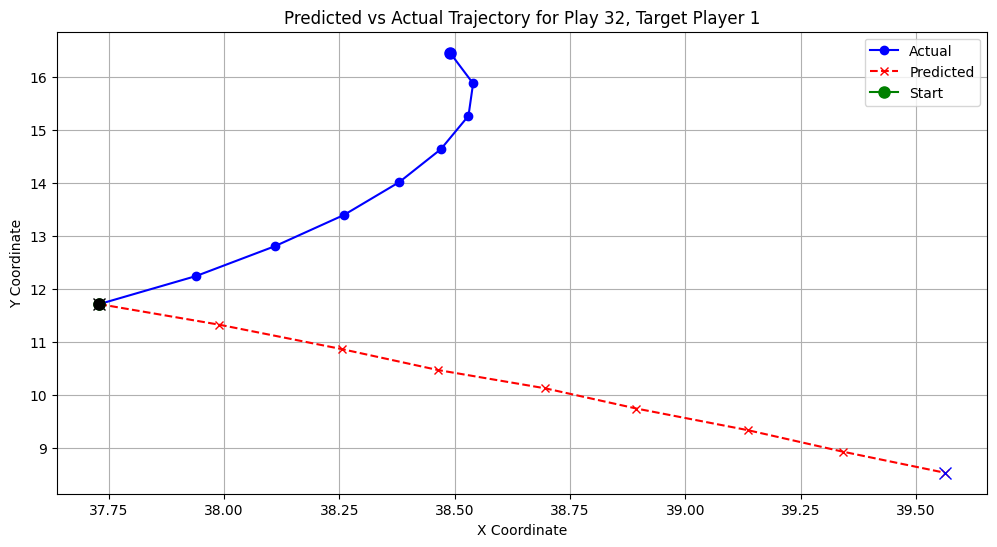

In [54]:
def visualize_predictions(model, data_loader, play_idx=0, target_player_idx=0):

    model.eval()

    with torch.no_grad():
        for batch_sequence, batch_targets, batch_masks, batch_start_pos, batch_input_lengths, batch_output_lengths, batch_player_pos in data_loader:
            batch_sequence = batch_sequence.to('cuda')
            batch_targets = batch_targets.to('cuda')
            batch_masks = batch_masks.to('cuda')
            batch_start_pos = batch_start_pos.to('cuda')
            batch_input_lengths = batch_input_lengths.to('cuda')
            batch_output_lengths = batch_output_lengths.to('cuda')
            batch_player_pos = batch_player_pos.to('cuda')

            val_predictions = model(batch_sequence, batch_start_pos, batch_masks,
                                    batch_input_lengths, target_seq = batch_targets,
                                    player_positions = batch_player_pos, train=False)

            predicted_delta = val_predictions[play_idx, target_player_idx, :, :].cpu().numpy()
            actual_delta = batch_targets[play_idx, target_player_idx, :, :].cpu().numpy()
            output_length = batch_output_lengths[play_idx].cpu().numpy()
            start = batch_start_pos[play_idx, target_player_idx, :].cpu().numpy()

            pred_deltas = predicted_delta[:output_length]
            actual_deltas = actual_delta[:output_length]

            #
            pred_deltas_unscaled = delta.inverse_transform(pred_deltas[:, :2])
            actual_deltas_unscaled = delta.inverse_transform(actual_deltas[:, :2])

            # Unscale start position
            start_unscaled = pos.inverse_transform(start.reshape(1, -1)).flatten()

            # Reconstruct path
            pred_path = np.cumsum(pred_deltas_unscaled, axis=0) + start_unscaled
            actual_path = np.cumsum(actual_deltas_unscaled, axis=0) + start_unscaled

            # start point
            predicted_trajectory = np.vstack([start_unscaled, pred_path])
            actual_trajectory = np.vstack([start_unscaled, actual_path])

            # plot trajectory
            plt.figure(figsize=(12, 6))
            plt.plot(actual_trajectory[:, 0], actual_trajectory[:, 1], marker='o', linestyle='-', color='blue', label='Actual')
            plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], marker='x', linestyle='--', color='red', label='Predicted')
            plt.plot(start_unscaled[0], start_unscaled[1], marker='o', color='green', markersize=8, label='Start')
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
            plt.title(f'Predicted vs Actual Trajectory for Play {play_idx}, Target Player {target_player_idx}')
            plt.legend()
            plt.grid(True)

            # first point in black (start)
            plt.plot(actual_trajectory[0, 0], actual_trajectory[0, 1], marker='o', color='black', markersize=8)
            plt.plot(predicted_trajectory[0, 0], predicted_trajectory[0, 1], marker='x', color='black', markersize=8)

            # last point blue
            plt.plot(actual_trajectory[-1, 0], actual_trajectory[-1, 1], marker='o', color='blue', markersize=8)
            plt.plot(predicted_trajectory[-1, 0], predicted_trajectory[-1, 1], marker='x', color='blue', markersize=8)

            plt.show()

            break

visualize_predictions(model, test_loader, play_idx=32, target_player_idx=1)

In [ ]:
visualize_predictions(model, train_loader, play_idx=5, target_player_idx=1)
visualize_predictions(model, train_loader, play_idx=13, target_player_idx=2)
visualize_predictions(model, train_loader, play_idx=15, target_player_idx=1)
visualize_predictions(model, train_loader, play_idx=17, target_player_idx=1)